In [1]:
import tensorflow as tf

tf.__version__


2024-02-26 22:21:32.250379: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 22:21:32.330314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 22:21:32.330487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 22:21:32.333130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 22:21:32.348950: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 22:21:32.350103: I tensorflow/core/platform/cpu_feature_guard.cc:1

'2.15.0'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [5]:
PATH


'/home/beenotung/.keras/datasets/cats_and_dogs_filtered'

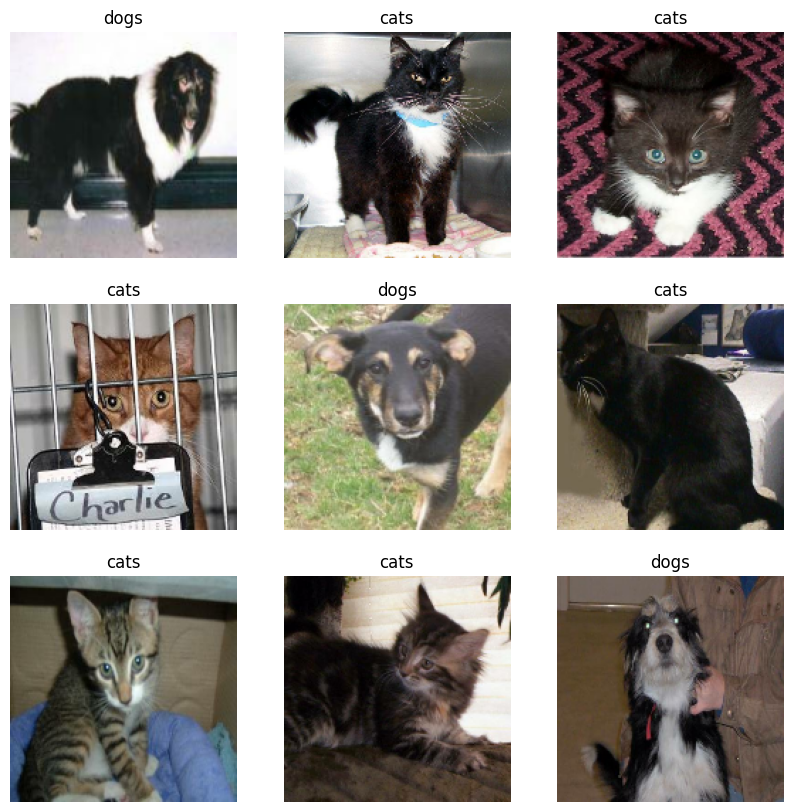

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


In [ ]:

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


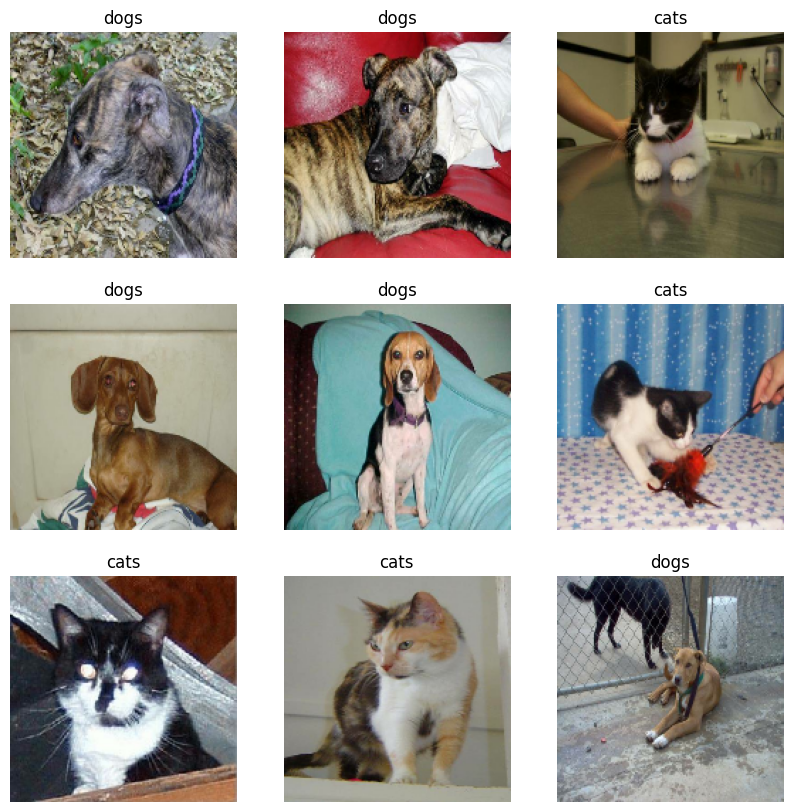

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


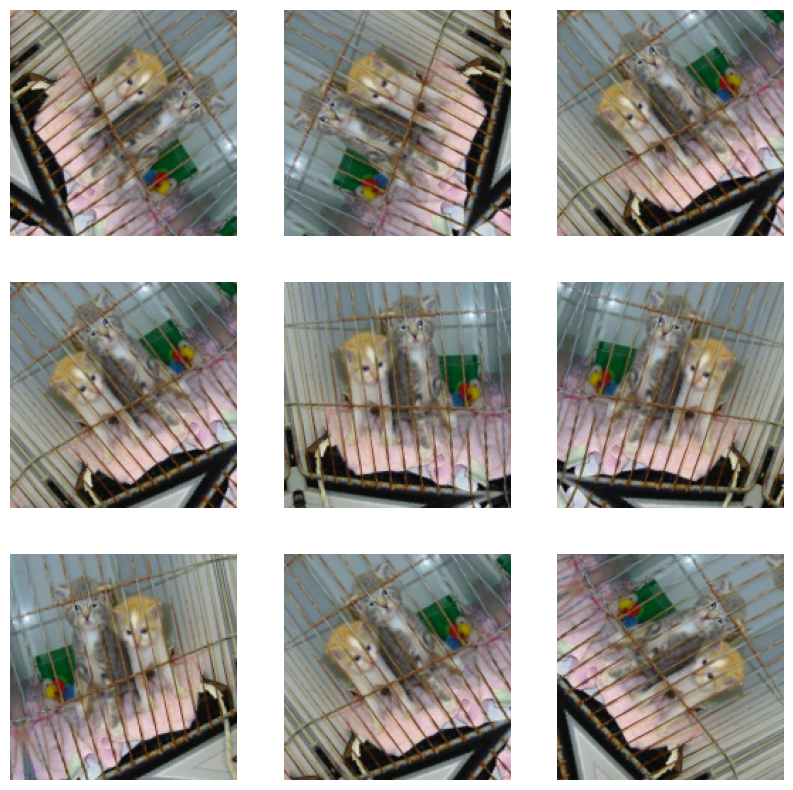

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [17]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [18]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


2024-02-26 22:30:09.042124: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2024-02-26 22:30:09.082859: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2024-02-26 22:30:09.161963: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2024-02-26 22:30:09.206824: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80621568 exceeds 10% of free system memory.


(32, 5, 5, 1280)


In [20]:
base_model.trainable = False


In [21]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [24]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [25]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])


In [28]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


2024-02-26 22:34:16.767545: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.


26/26 [==============================] - 18s 590ms/step - loss: 0.7723 - accuracy: 0.4554


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
63/63 [==============================] - 69s 971ms/step - loss: 0.7119 - accuracy: 0.5820 - val_loss: 0.5331 - val_accuracy: 0.7500
Epoch 2/10
63/63 [==============================] - 63s 1s/step - loss: 0.5445 - accuracy: 0.7230 - val_loss: 0.3906 - val_accuracy: 0.8639
Epoch 3/10
63/63 [==============================] - 87s 1s/step - loss: 0.4401 - accuracy: 0.8060 - val_loss: 0.3006 - val_accuracy: 0.9245
Epoch 4/10
63/63 [==============================] - 56s 893ms/step - loss: 0.3597 - accuracy: 0.8580 - val_loss: 0.2422 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 82s 1s/step - loss: 0.3106 - accuracy: 0.8805 - val_loss: 0.2143 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 74s 1s/step - loss: 0.2978 - accuracy: 0.8885 - val_loss: 0.1849 - val_accuracy: 0.9567
Epoch 7/10
63/63 [==============================] - 55s 865ms/step - loss: 0.2691 - accuracy: 0.8950 - val_loss: 0.1679 - val_accuracy: 0.9629
Epoch 8/10


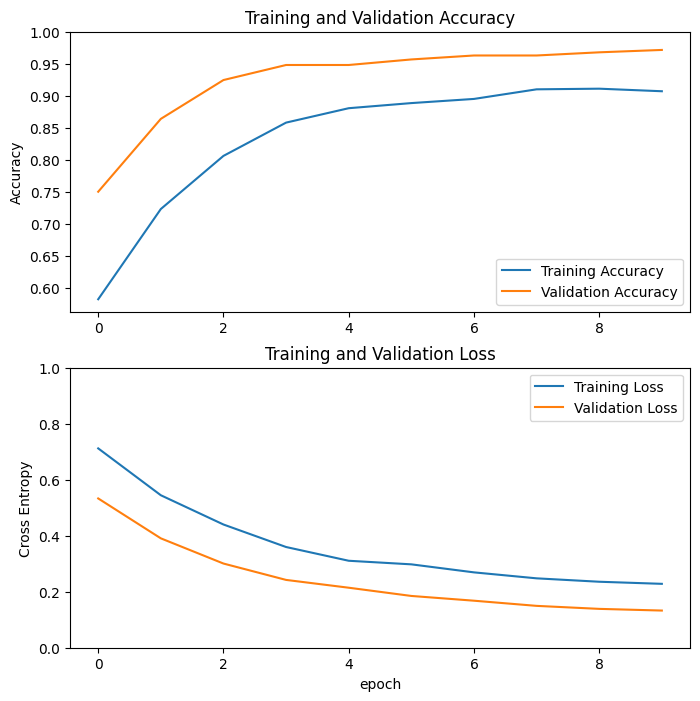

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [31]:
model.save('saved-model')


INFO:tensorflow:Assets written to: saved-model/assets


INFO:tensorflow:Assets written to: saved-model/assets
